# 11차시: API란 무엇인가? (Open DART, FRED API)

## 학습 목표
- API의 개념과 작동 원리 이해
- JSON 데이터 형식 이해 및 파싱
- DART(공시), FRED(경제지표) 등 유용한 금융 API 소개

## 학습 내용
1. API란 무엇인가?
2. JSON 데이터 형식 이해
3. API 작동 원리 (요청과 응답)
4. API 키 설정 (.env 파일)
5. Open DART API 실습
6. FRED API 실습
7. 기타 유용한 금융 API


In [1]:
# 라이브러리 설치
!pip install -q python-dotenv koreanize-matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 36.0 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import koreanize_matplotlib
import matplotlib.dates as mdates
from datetime import datetime, timedelta

---
## 1. API란 무엇인가?

### API (Application Programming Interface) 정의
- **프로그램과 프로그램 사이의 연결 통로**
- 서로 다른 소프트웨어가 데이터를 주고받을 수 있게 해주는 인터페이스
- 마치 식당의 메뉴판처럼, "이렇게 요청하면 이런 데이터를 줄게"라고 약속한 규칙

### 일상 속 API 예시
| 상황 | API 역할 |
|------|----------|
| 카카오톡 로그인 | 카카오 API가 사용자 인증 정보 제공 |
| 네이버 지도 | 지도 API가 위치 정보 제공 |
| 날씨 앱 | 기상청 API가 날씨 데이터 제공 |
| 주식 앱 | 거래소 API가 시세 데이터 제공 |

### 금융 데이터 수집에서 API의 중요성
- **자동화**: 수작업 없이 프로그램으로 데이터 수집
- **실시간성**: 최신 데이터를 즉시 가져올 수 있음
- **정확성**: 원천 데이터 제공자로부터 직접 수신
- **대량 수집**: 많은 양의 데이터를 빠르게 수집

---
## 2. JSON 데이터 형식 이해

### JSON (JavaScript Object Notation)
- API에서 데이터를 주고받을 때 가장 많이 사용하는 형식
- 사람이 읽기 쉽고, 프로그램이 처리하기 쉬움
- **키(Key)와 값(Value) 쌍**으로 구성

### JSON vs Python 비교
| JSON | Python |
|------|--------|
| {} (객체) | dict (딕셔너리) |
| [] (배열) | list (리스트) |
| "문자열" | "문자열" |
| 숫자 | 숫자 |
| true/false | True/False |
| null | None |

In [3]:
# JSON 예제 - 주식 데이터 형식
import json

# JSON 문자열 (API 응답 형태)
json_string = '''
{
    "stock_name": "삼성전자",
    "stock_code": "005930",
    "date": "2024-12-20",
    "price": {
        "open": 53000,
        "high": 54000,
        "low": 52500,
        "close": 53500
    },
    "volume": 15000000,
    "is_trading": true
}
'''

# JSON 문자열 → Python 딕셔너리 변환
data = json.loads(json_string)

print("[JSON → Python 변환 예제]")
print("=" * 60)
print(f"종목명: {data['stock_name']}")
print(f"종목코드: {data['stock_code']}")
print(f"종가: {data['price']['close']:,}원")
print(f"거래량: {data['volume']:,}주")
print(f"거래 여부: {data['is_trading']}")

[JSON → Python 변환 예제]
종목명: 삼성전자
종목코드: 005930
종가: 53,500원
거래량: 15,000,000주
거래 여부: True


In [4]:
# JSON 중첩 구조 접근
print("\n[중첩된 JSON 데이터 접근]")
print("=" * 60)

# 복잡한 JSON 예제 (여러 종목 데이터)
multi_stock_json = '''
{
    "response_time": "2024-12-20 15:30:00",
    "count": 3,
    "stocks": [
        {"name": "삼성전자", "code": "005930", "price": 53500},
        {"name": "SK하이닉스", "code": "000660", "price": 178000},
        {"name": "NAVER", "code": "035420", "price": 195000}
    ]
}
'''

multi_data = json.loads(multi_stock_json)

print(f"응답 시간: {multi_data['response_time']}")
print(f"종목 수: {multi_data['count']}")
print("\n[종목 리스트]")
for stock in multi_data['stocks']:
    print(f"  - {stock['name']} ({stock['code']}): {stock['price']:,}원")


[중첩된 JSON 데이터 접근]
응답 시간: 2024-12-20 15:30:00
종목 수: 3

[종목 리스트]
  - 삼성전자 (005930): 53,500원
  - SK하이닉스 (000660): 178,000원
  - NAVER (035420): 195,000원


---
## 3. API 작동 원리 (요청과 응답)

### REST API 기본 구조
```
[클라이언트] ──요청(Request)──> [API 서버] ──응답(Response)──> [클라이언트]
    (우리 프로그램)                 (데이터 제공자)                (우리 프로그램)
```

### HTTP 요청 구성 요소
| 구성 요소 | 설명 | 예시 |
|----------|------|------|
| **URL (Endpoint)** | API 주소 | `https://api.dart.fss.or.kr/api/...` |
| **HTTP 메서드** | 요청 종류 | GET (조회), POST (전송) |
| **파라미터** | 추가 조건 | `?corp_code=00126380&bsns_year=2023` |
| **헤더** | 인증 정보 등 | API 키, Content-Type |

### API 키 (API Key)
- API를 사용하기 위한 **인증 수단**
- 누가 API를 사용하는지 식별
- 대부분의 금융 API는 회원가입 후 API 키 발급 필요

---
## 4. API 키 설정 (.env 파일)

API 키는 코드에 직접 작성하지 않고 `.env` 파일에 저장하여 관리합니다.
이렇게 하면 코드를 공유해도 API 키가 노출되지 않습니다.

### .env 파일 형식
```
DART_API_KEY=발급받은_DART_API_키
FRED_API_KEY=발급받은_FRED_API_키
```

### API 키 발급 방법
- **Open DART**: https://opendart.fss.or.kr/ → 회원가입 → 인증키 신청
- **FRED**: https://fred.stlouisfed.org/ → My Account → API Keys

In [5]:
# API 키 로드 (Colab에서 .env 파일 업로드)
from google.colab import files
import os
from dotenv import load_dotenv

print("[.env 파일 업로드]")
print("=" * 60)
print("로컬에 저장된 .env 파일을 선택해주세요.")
print("(DART_API_KEY, FRED_API_KEY가 포함된 파일)")
print()

uploaded = files.upload()

# .env 파일 로드
load_dotenv('.env')

DART_API_KEY = os.getenv('DART_API_KEY')
FRED_API_KEY = os.getenv('FRED_API_KEY')

# API 키 로드 확인
print("\n[API 키 로드 상태]")
print("=" * 60)
if DART_API_KEY:
    print(f"DART API Key: 설정완료 ({DART_API_KEY[:8]}...)")
else:
    print("DART API Key: 미설정")

if FRED_API_KEY:
    print(f"FRED API Key: 설정완료 ({FRED_API_KEY[:8]}...)")
else:
    print("FRED API Key: 미설정")

[.env 파일 업로드]
로컬에 저장된 .env 파일을 선택해주세요.
(DART_API_KEY, FRED_API_KEY가 포함된 파일)



Saving .env to .env

[API 키 로드 상태]
DART API Key: 설정완료 (1493d0f2...)
FRED API Key: 설정완료 (061718d0...)


---
## 5. Open DART API 실습

### Open DART란?
- **금융감독원 전자공시시스템(DART)**의 공개 API
- 상장기업의 공시 정보를 프로그램으로 조회 가능
- 무료 사용 (일 10,000건 제한)

### 주요 제공 데이터
| 분류 | 내용 |
|------|------|
| **공시 정보** | 사업보고서, 반기보고서, 분기보고서 |
| **재무제표** | 손익계산서, 재무상태표, 현금흐름표 |
| **기업 개황** | 기업명, 대표자, 업종, 주소 등 |
| **주요 사항** | 배당, 증자, 합병, 임원 변동 등 |

### Open DART API 구조
```
https://opendart.fss.or.kr/api/{서비스명}.json?crtfc_key={API키}&{파라미터}
```

In [6]:
# Open DART API 주요 서비스
print("[Open DART API 주요 서비스]")
print("=" * 60)

dart_api_info = {
    "base_url": "https://opendart.fss.or.kr/api/",
    "services": {
        "company.json": "기업개황 조회",
        "fnlttSinglAcnt.json": "단일회사 전체 재무제표",
        "fnlttMultiAcnt.json": "다중회사 주요계정",
        "list.json": "공시 목록 조회",
        "document.xml": "공시 원문 조회"
    }
}

print(f"기본 URL: {dart_api_info['base_url']}")
print("\n[주요 서비스 (Endpoint)]")
for endpoint, desc in dart_api_info['services'].items():
    print(f"  - {endpoint}: {desc}")

[Open DART API 주요 서비스]
기본 URL: https://opendart.fss.or.kr/api/

[주요 서비스 (Endpoint)]
  - company.json: 기업개황 조회
  - fnlttSinglAcnt.json: 단일회사 전체 재무제표
  - fnlttMultiAcnt.json: 다중회사 주요계정
  - list.json: 공시 목록 조회
  - document.xml: 공시 원문 조회


In [7]:
# 삼성전자 기업 개황 조회
import requests

print("\n[삼성전자 기업 개황 조회]")
print("=" * 60)

url = "https://opendart.fss.or.kr/api/company.json"
params = {
    "crtfc_key": DART_API_KEY,
    "corp_code": "00126380"  # 삼성전자 고유번호
}

response = requests.get(url, params=params)

if response.status_code == 200:
    data = response.json()

    if data['status'] == '000':  # 정상
        print(f"기업명: {data['corp_name']}")
        print(f"영문명: {data['corp_name_eng']}")
        print(f"종목코드: {data['stock_code']}")
        print(f"대표자: {data['ceo_nm']}")
        print(f"법인구분: {data['corp_cls']}")
        print(f"설립일: {data['est_dt']}")
        print(f"홈페이지: {data['hm_url']}")
        print(f"주소: {data['adres']}")
    else:
        print(f"오류: {data['status']} - {data['message']}")
else:
    print(f"HTTP 오류: {response.status_code}")


[삼성전자 기업 개황 조회]
기업명: 삼성전자(주)
영문명: SAMSUNG ELECTRONICS CO,.LTD
종목코드: 005930
대표자: 전영현, 노태문
법인구분: Y
설립일: 19690113
홈페이지: www.samsung.com/sec
주소: 경기도 수원시 영통구  삼성로 129 (매탄동)


In [8]:
# 삼성전자 최근 공시 목록 조회
print("\n[삼성전자 최근 공시 목록 조회]")
print("=" * 60)

url = "https://opendart.fss.or.kr/api/list.json"
params = {
    "crtfc_key": DART_API_KEY,
    "corp_code": "00126380",  # 삼성전자 고유번호
    "bgn_de": "20240101",     # 시작일 (YYYYMMDD)
    "end_de": "20241231",     # 종료일
    "page_count": "10"        # 조회할 공시 수
}

response = requests.get(url, params=params)

if response.status_code == 200:
    data = response.json()

    if data['status'] == '000':  # 정상 응답
        print(f"총 공시 수: {data['total_count']}건")
        print(f"조회된 공시: {len(data['list'])}건\n")

        # DataFrame으로 변환
        df = pd.DataFrame(data['list'])
        df_display = df[['rcept_dt', 'corp_name', 'report_nm', 'flr_nm']]
        df_display.columns = ['접수일자', '회사명', '보고서명', '제출인']

        print(df_display.to_string(index=False))
    else:
        print(f"오류: {data['status']} - {data['message']}")
else:
    print(f"HTTP 오류: {response.status_code}")


[삼성전자 최근 공시 목록 조회]
총 공시 수: 284건
조회된 공시: 10건

    접수일자  회사명                             보고서명  제출인
20241223 삼성전자              임원ㆍ주요주주특정증권등소유상황보고서  김상하
20241223 삼성전자 [기재정정]기타경영사항(자율공시)               삼성전자
20241220 삼성전자                주식등의대량보유상황보고서(일반) 삼성물산
20241219 삼성전자              임원ㆍ주요주주특정증권등소유상황보고서  홍준화
20241217 삼성전자              임원ㆍ주요주주특정증권등소유상황보고서  송기재
20241212 삼성전자              임원ㆍ주요주주특정증권등소유상황보고서  강종호
20241212 삼성전자              임원ㆍ주요주주특정증권등소유상황보고서  김진철
20241211 삼성전자              임원ㆍ주요주주특정증권등소유상황보고서  한기욱
20241209 삼성전자              임원ㆍ주요주주특정증권등소유상황보고서  박상훈
20241209 삼성전자              임원ㆍ주요주주특정증권등소유상황보고서  이석림


- **A**: 정기보고서 (사업/반기/분기보고서)
- **B**: 주요사항보고
- **C**: 발행공시
- **D**: 지분공시
- **E**: 기타공시
- **F**: 외부감사관련
- **G**: 펀드공시
- **H**: 자산유동화
- **I**: 거래소공시
- **J**: 공정위공시

In [9]:
# 삼성전자 정기보고서만 조회
print("\n[삼성전자 정기보고서 목록]")
print("=" * 60)

params_annual = {
    "crtfc_key": DART_API_KEY,
    "corp_code": "00126380",
    "bgn_de": "20230101",
    "pblntf_ty": "A",  # 정기보고서만
    "page_count": "10"
}

response = requests.get("https://opendart.fss.or.kr/api/list.json", params=params_annual)
data = response.json()

if data['status'] == '000':
    print(f"총 {data['total_count']}건\n")
    for item in data['list'][:10]:
        print(f"  {item['rcept_dt']} | {item['report_nm']}")
else:
    print(f"오류: {data['status']} - {data.get('message', '')}")


[삼성전자 정기보고서 목록]
총 12건

  20251114 | 분기보고서 (2025.09)
  20250814 | 반기보고서 (2025.06)
  20250515 | 분기보고서 (2025.03)
  20250311 | 사업보고서 (2024.12)
  20241114 | 분기보고서 (2024.09)
  20240814 | 반기보고서 (2024.06)
  20240516 | 분기보고서 (2024.03)
  20240312 | 사업보고서 (2023.12)
  20231114 | 분기보고서 (2023.09)
  20230814 | 반기보고서 (2023.06)


---
## 6. FRED API 실습

### FRED란?
- **Federal Reserve Economic Data**
- 미국 세인트루이스 연방준비은행에서 제공하는 경제 데이터베이스
- **80만개 이상**의 경제 시계열 데이터 보유

### 주요 제공 데이터
| 분류 | 지표 예시 |
|------|----------|
| **금리** | 기준금리, 국채수익률 |
| **물가** | CPI, PPI, PCE |
| **고용** | 실업률, 비농업고용 |
| **GDP** | 실질GDP, 명목GDP |
| **환율** | 달러 인덱스, 주요 환율 |

In [10]:
# FRED 주요 경제지표 코드
print("[FRED 주요 경제지표 코드]")
print("=" * 60)

fred_series = {
    "금리": {
        "FEDFUNDS": "연방기금금리 (Fed Funds Rate)",
        "DGS10": "10년 국채 수익률",
        "DGS2": "2년 국채 수익률",
        "T10Y2Y": "10년-2년 국채 스프레드"
    },
    "물가": {
        "CPIAUCSL": "소비자물가지수 (CPI)",
        "PCEPI": "개인소비지출 물가지수 (PCE)",
        "PPIFIS": "생산자물가지수 (PPI)"
    },
    "고용": {
        "UNRATE": "실업률",
        "PAYEMS": "비농업 고용자 수",
        "ICSA": "주간 신규 실업수당 청구"
    },
    "GDP/성장": {
        "GDP": "명목 GDP",
        "GDPC1": "실질 GDP",
        "A191RL1Q225SBEA": "실질 GDP 성장률"
    },
    "환율": {
        "DEXKOUS": "원/달러 환율",
        "DEXJPUS": "엔/달러 환율",
        "DTWEXBGS": "달러 인덱스"
    }
}

for category, series in fred_series.items():
    print(f"\n[{category}]")
    for code, name in series.items():
        print(f"  - {code}: {name}")

[FRED 주요 경제지표 코드]

[금리]
  - FEDFUNDS: 연방기금금리 (Fed Funds Rate)
  - DGS10: 10년 국채 수익률
  - DGS2: 2년 국채 수익률
  - T10Y2Y: 10년-2년 국채 스프레드

[물가]
  - CPIAUCSL: 소비자물가지수 (CPI)
  - PCEPI: 개인소비지출 물가지수 (PCE)
  - PPIFIS: 생산자물가지수 (PPI)

[고용]
  - UNRATE: 실업률
  - PAYEMS: 비농업 고용자 수
  - ICSA: 주간 신규 실업수당 청구

[GDP/성장]
  - GDP: 명목 GDP
  - GDPC1: 실질 GDP
  - A191RL1Q225SBEA: 실질 GDP 성장률

[환율]
  - DEXKOUS: 원/달러 환율
  - DEXJPUS: 엔/달러 환율
  - DTWEXBGS: 달러 인덱스


In [11]:
# FRED API로 미국 실업률 조회
print("\n[FRED API: 미국 실업률 조회]")
print("=" * 60)

url = "https://api.stlouisfed.org/fred/series/observations"
params = {
    "api_key": FRED_API_KEY,
    "series_id": "UNRATE",      # 미국 실업률
    "file_type": "json",
    "observation_start": "2023-01-01",
    "observation_end": "2024-12-31"
}

response = requests.get(url, params=params)

if response.status_code == 200:
    data = response.json()

    if 'observations' in data:
        observations = data['observations']

        # DataFrame으로 변환
        df_fred = pd.DataFrame(observations)
        df_fred['date'] = pd.to_datetime(df_fred['date'])
        df_fred['value'] = pd.to_numeric(df_fred['value'], errors='coerce')

        print(f"데이터 수: {len(df_fred)}개")
        print(f"\n최근 5개 데이터:")
        print(df_fred[['date', 'value']].tail().to_string(index=False))
    else:
        print(f"오류: {data.get('error_message', '알 수 없는 오류')}")
else:
    print(f"HTTP 오류: {response.status_code}")


[FRED API: 미국 실업률 조회]
데이터 수: 24개

최근 5개 데이터:
      date  value
2024-08-01    4.2
2024-09-01    4.1
2024-10-01    4.1
2024-11-01    4.2
2024-12-01    4.1



[미국 실업률 추이 시각화]


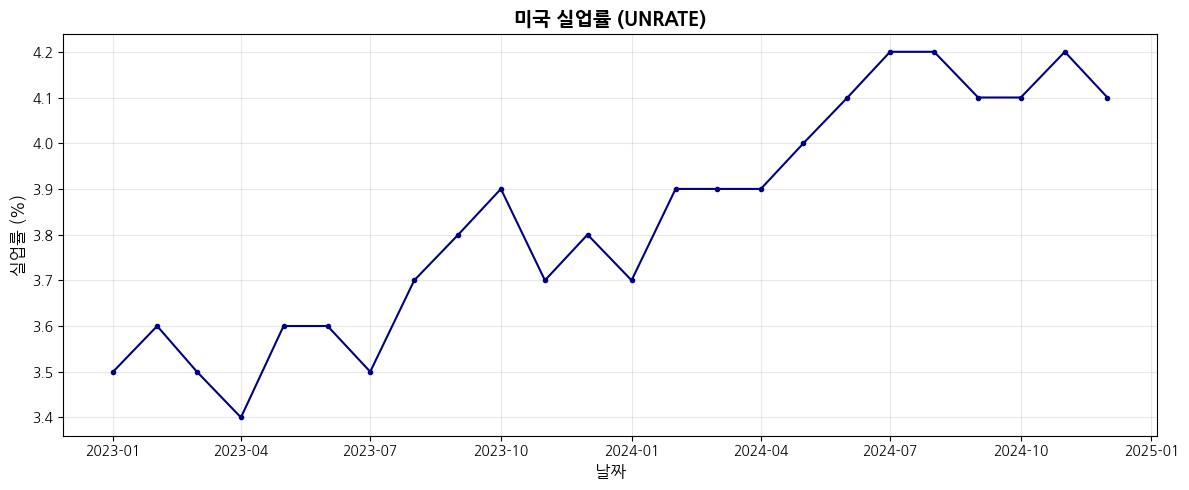

In [12]:
# FRED 실업률 시각화
print("\n[미국 실업률 추이 시각화]")
print("=" * 60)

if 'df_fred' in dir() and len(df_fred) > 0:
    plt.figure(figsize=(12, 5))
    plt.plot(df_fred['date'], df_fred['value'], color='navy', linewidth=1.5, marker='o', markersize=3)
    plt.title('미국 실업률 (UNRATE)', fontsize=14, fontweight='bold')
    plt.xlabel('날짜', fontsize=12)
    plt.ylabel('실업률 (%)', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("데이터가 없습니다. FRED API 호출을 먼저 실행해주세요.")

In [13]:
# pandas-datareader로 FRED 데이터 조회 (API 키 불필요한 방법)
print("\n[pandas-datareader로 FRED 데이터 조회]")
print("=" * 60)
print("(pandas-datareader는 API 키 없이도 FRED 데이터 조회 가능)")

try:
    import pandas_datareader as pdr
    from datetime import datetime

    # 원/달러 환율 조회
    start = datetime(2023, 1, 1)
    end = datetime(2024, 12, 31)

    print("\n원/달러 환율 (DEXKOUS) 조회 중...")
    df_exchange = pdr.DataReader('DEXKOUS', 'fred', start, end)

    print(f"\n데이터 수: {len(df_exchange)}개")
    print(f"기간: {df_exchange.index[0].strftime('%Y-%m-%d')} ~ {df_exchange.index[-1].strftime('%Y-%m-%d')}")
    print(f"\n최근 5개 데이터:")
    print(df_exchange.tail())

except ImportError:
    print("pandas-datareader가 설치되어 있지 않습니다.")
    print("설치: pip install pandas-datareader")
except Exception as e:
    print(f"데이터 조회 중 오류 발생: {e}")


[pandas-datareader로 FRED 데이터 조회]
(pandas-datareader는 API 키 없이도 FRED 데이터 조회 가능)

원/달러 환율 (DEXKOUS) 조회 중...

데이터 수: 522개
기간: 2023-01-02 ~ 2024-12-31

최근 5개 데이터:
            DEXKOUS
DATE               
2024-12-25      NaN
2024-12-26  1467.66
2024-12-27  1470.40
2024-12-30  1472.32
2024-12-31  1477.86



[FRED 경제지표 시각화]
데이터 조회 중...


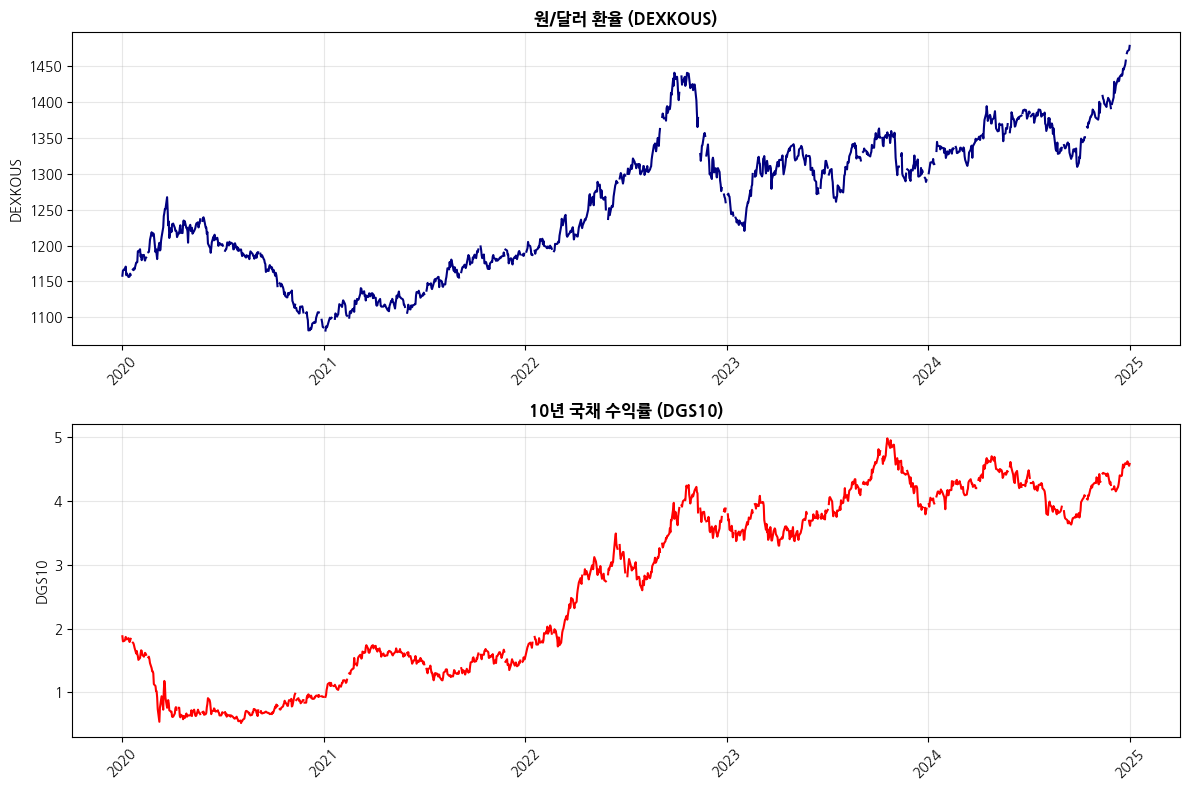

시각화 완료!


In [14]:
# FRED 데이터 시각화 (여러 지표)
print("\n[FRED 경제지표 시각화]")
print("=" * 60)

try:
    import pandas_datareader as pdr
    from datetime import datetime

    start = datetime(2020, 1, 1)
    end = datetime(2024, 12, 31)

    # 여러 지표 조회
    print("데이터 조회 중...")
    indicators = {
        'DEXKOUS': '원/달러 환율',
        'DGS10': '10년 국채 수익률'
    }

    fig, axes = plt.subplots(2, 1, figsize=(12, 8))

    for idx, (code, name) in enumerate(indicators.items()):
        df = pdr.DataReader(code, 'fred', start, end)
        axes[idx].plot(df.index, df[code], color=['navy', 'red'][idx], linewidth=1.5)
        axes[idx].set_title(f'{name} ({code})', fontsize=12, fontweight='bold')
        axes[idx].set_ylabel(code)
        axes[idx].grid(True, alpha=0.3)
        axes[idx].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

    print("시각화 완료!")

except ImportError:
    print("필요한 라이브러리가 설치되어 있지 않습니다.")
except Exception as e:
    print(f"오류 발생: {e}")

---
## 7. 기타 유용한 금융 API

### 국내 금융 API
| API | 제공 기관 | 주요 데이터 |
|-----|----------|------------|
| **Open DART** | 금융감독원 | 기업 공시, 재무제표 |
| **공공데이터포털** | 행정안전부 | 다양한 공공데이터 |
| **KRX 정보데이터시스템** | 한국거래소 | 주식, 채권, 파생상품 |
| **한국은행 경제통계시스템** | 한국은행 | 금리, 통화, 경제지표 |

### 해외 금융 API
| API | 제공 기관 | 주요 데이터 |
|-----|----------|------------|
| **FRED** | 미국 연준 | 경제지표, 금리, 환율 |
| **Alpha Vantage** | Alpha Vantage | 주식, 암호화폐, 기술지표 |
| **Yahoo Finance** | Yahoo | 글로벌 주식, ETF |
| **Quandl** | Nasdaq | 금융, 경제 데이터 |

### Python 라이브러리 (API 키 불필요)
| 라이브러리 | 설명 |
|-----------|------|
| **FinanceDataReader** | 한국거래소 데이터 |
| **FinanceDataReader** | 국내외 금융 데이터 |
| **yfinance** | Yahoo Finance 데이터 |
| **pandas-datareader** | 다양한 데이터 소스 지원 |

In [15]:
# API 비교 정리
print("[금융 API 비교 정리]")
print("=" * 60)

api_comparison = """
| 구분 | Open DART | FRED | FinanceDataReader |
|------|-----------|------|-------|
| API 키 | 필요 | 필요 | 불필요 |
| 무료 사용 | O (일 10,000건) | O (무제한) | O |
| 데이터 종류 | 공시, 재무제표 | 경제지표 | 주가 |
| 대상 국가 | 한국 | 미국/글로벌 | 한국 |
| 응답 형식 | JSON/XML | JSON/XML | DataFrame |
"""
print(api_comparison)

print("\n[API 선택 가이드]")
print("-" * 60)
print("  - 기업 재무제표/공시 -> Open DART API")
print("  - 글로벌 경제지표 -> FRED API")
print("  - 한국 주가 데이터 -> FinanceDataReader (API 키 불필요)")
print("  - 해외 주가 데이터 -> yfinance, Alpha Vantage")

[금융 API 비교 정리]

| 구분 | Open DART | FRED | FinanceDataReader |
|------|-----------|------|-------|
| API 키 | 필요 | 필요 | 불필요 |
| 무료 사용 | O (일 10,000건) | O (무제한) | O |
| 데이터 종류 | 공시, 재무제표 | 경제지표 | 주가 |
| 대상 국가 | 한국 | 미국/글로벌 | 한국 |
| 응답 형식 | JSON/XML | JSON/XML | DataFrame |


[API 선택 가이드]
------------------------------------------------------------
  - 기업 재무제표/공시 -> Open DART API
  - 글로벌 경제지표 -> FRED API
  - 한국 주가 데이터 -> FinanceDataReader (API 키 불필요)
  - 해외 주가 데이터 -> yfinance, Alpha Vantage


---
## 학습 정리

### 1. API 개념
- **API**: 프로그램 간 데이터를 주고받는 인터페이스
- **REST API**: HTTP 프로토콜 기반의 API 표준
- **API 키**: API 사용을 위한 인증 수단

### 2. JSON 데이터 형식
- API에서 가장 많이 사용하는 데이터 형식
- Python의 딕셔너리/리스트와 유사한 구조
- `json.loads()`: JSON -> Python
- `json.dumps()`: Python -> JSON

### 3. API 키 관리
- `.env` 파일에 API 키 저장
- `python-dotenv`로 환경 변수 로드
- 코드에 API 키 직접 노출 금지

### 4. 주요 금융 API
- **Open DART**: 기업 공시, 재무제표 (한국)
- **FRED**: 경제지표, 금리, 환율 (미국)
- **FinanceDataReader**: 한국 주식 데이터 (API 키 불필요)

### 5. API 호출 기본
```python
import requests
response = requests.get(url, params=params)
data = response.json()
```

---

### 다음 차시 예고
- 12차시: [실습] Open DART API로 공시 정보 수집
  - 재무제표 데이터 수집
  - 데이터 가공 및 분석